In [30]:
import pandas as pd
import os
import pysrt #pip install pysrt библиотеки pysrt, которая используется для работы с файлами субтитров
import re # регулярные выражения
import nltk
import catboost as cb
import numpy as np

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [31]:
# Загрузка модулей
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [32]:
# Загрузим предварительно сформированные данные о сложности слов согласно Оксфордского словаря
df_words = pd.read_csv(r'C:\English_level\Oxford_dikt.csv')

df_movies = pd.read_excel(r'C:\English_level\movies_labels.xlsx')
print (df_movies)

      id                             Movie   Level
0      0         10_Cloverfield_lane(2016)      B1
1      1  10_things_I_hate_about_you(1999)      B1
2      2              A_knights_tale(2001)      B2
3      3              A_star_is_born(2018)      B2
4      4                     Aladdin(1992)  A2/A2+
..   ...                               ...     ...
236  236                     Matilda(2022)      C1
237  237                      Bullet train      B1
238  238            Thor: love and thunder      B2
239  239                         Lightyear      B2
240  240                        The Grinch      B1

[241 rows x 3 columns]


## Преданализ данных

In [33]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241 entries, 0 to 240
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      241 non-null    int64 
 1   Movie   241 non-null    object
 2   Level   241 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.8+ KB


In [34]:
# Найём дублирующиеся строки
duplicated_rows = df_movies[df_movies.duplicated()]

# Выведим количество дублирующихся строк
print(f"Количество дублирующихся строк: {duplicated_rows.shape[0]}")

# Выведим дублирующиеся строки, если они есть
if not duplicated_rows.empty:
    print("Дублирующиеся строки:")
    display(duplicated_rows)
else:
    print("Дублирующихся строк не найдено.")

Количество дублирующихся строк: 0
Дублирующихся строк не найдено.


In [35]:
# Вычисляем процент пропущенных значений для каждого столбца и округляем их
missing_percentage = pd.DataFrame(round(df_movies.isna().mean() * 100,))
missing_count = pd.DataFrame(df_movies.isna().sum())
missing_data = pd.concat([missing_percentage, missing_count], axis=1)
missing_data.columns = ['% пропусков', 'Кол-во пропусков']
sorted_missing_data = missing_data.sort_values(by='% пропусков', ascending=False)
styled_missing_data = sorted_missing_data.style.background_gradient('coolwarm', subset=['% пропусков'])
styled_missing_data

,% пропусков,Кол-во пропусков
id,0.000000,0
Movie,0.000000,0
Level,0.000000,0


In [36]:
df_movies['Level'].value_counts()

Level
B2            101
B1             55
C1             40
A2/A2+         26
B1, B2          8
A2              6
A2/A2+, B1      5
Name: count, dtype: int64

Классификация уровней владения иностранными языками Совета Европы
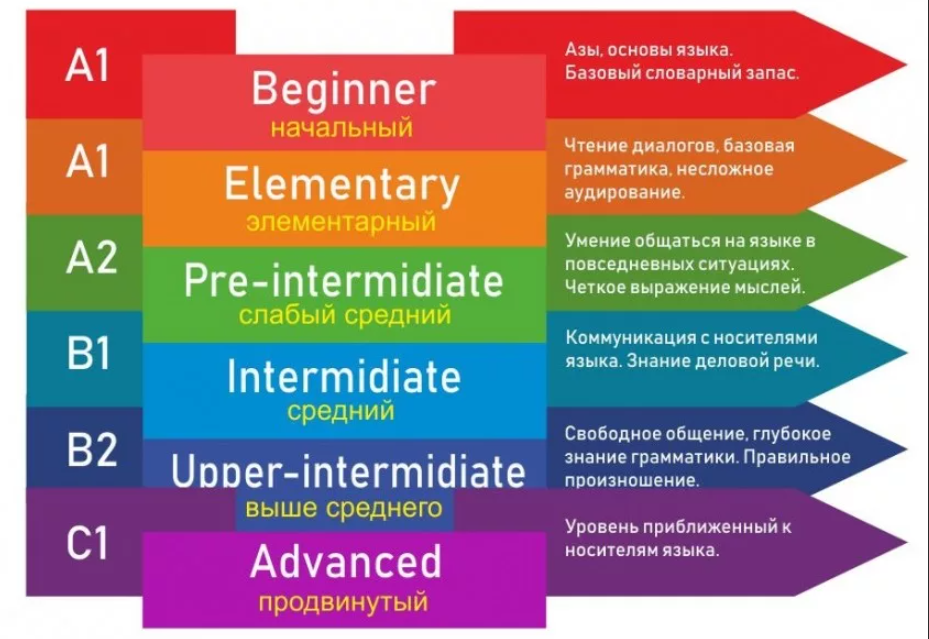

(Источник https://kiwieducation.ru/nz/lifehack/klassifikacziya-urovnej-vladeniya-inostrannymi-yazykami-soveta-evropy/)

In [37]:
df_movies.loc[df_movies['Level'] == "A2/A2+, B1"]

,id,Movie,Level
35,35,Forrest_Gump(1994),"A2/A2+, B1"
39,39,Her(2013),"A2/A2+, B1"
60,60,Moulin_Rouge(2001),"A2/A2+, B1"
87,87,The_fault_in_our_stars(2014),"A2/A2+, B1"
99,99,The_terminal(2004),"A2/A2+, B1"


In [38]:
df_movies.loc[df_movies['Level'] == "A2/A2+"]

,id,Movie,Level
4,4,Aladdin(1992),A2/A2+
5,5,All_dogs_go_to_heaven(1989),A2/A2+
6,6,An_American_tail(1986),A2/A2+
7,7,Babe(1995),A2/A2+
8,8,Back_to_the_future(1985),A2/A2+
10,10,Batman_begins(2005),A2/A2+
19,19,Cast_away(2000),A2/A2+
27,27,Dredd(2012),A2/A2+
31,31,Eurovision_song_contest_(2020),A2/A2+
34,34,Finding_Nemo(2003),A2/A2+


Для некоторых фильмов указаны уровни нескольких категорий:
1. A2/A2+ преобразуем к А2 так как категория А2+; B1, B2 преобразуем к B1; A2/A2+ преобразуем к B1.
2. Присутствует дисбаланс классов.

In [39]:
# Избавимся от не понятных категорий
df_movies['Level'] = df_movies['Level'].replace("A2/A2+", "A2")
df_movies['Level'] = df_movies['Level'].replace("A2/A2+, B1", "B1")
df_movies['Level'] = df_movies['Level'].replace("B1, B2", "B2")

In [40]:
df_movies['Level'].value_counts()

Level
B2    109
B1     60
C1     40
A2     32
Name: count, dtype: int64

In [41]:
# Кодируем целевую переменную
targets = {
           'A1':0, 
           'A2':1,
           'B1':2,
           'B2':3,
           'C1':4}
df_movies['target'] = df_movies['Level'].apply(lambda x: targets[x])
df_movies.head(5)

,id,Movie,Level,target
0,0,10_Cloverfield_lane(2016),B1,2
1,1,10_things_I_hate_about_you(1999),B1,2
2,2,A_knights_tale(2001),B2,3
3,3,A_star_is_born(2018),B2,3
4,4,Aladdin(1992),A2,1


In [42]:
# Получить список всех файлов в папке и создадим из них DataFrame с именами файлов
folder_path = 'C:/English_level/1/'
file_list = os.listdir(folder_path)
df_files = pd.DataFrame(file_list, columns=['file'])
df_files.head()

,file
0,10_Cloverfield_lane(2016).srt
1,10_things_I_hate_about_you(1999).srt
2,Aladdin(1992).srt
3,All_dogs_go_to_heaven(1989).srt
4,AmericanBeauty1999.BRRip.srt


In [43]:
# Найём дублирующиеся строки
duplicated_rows_files = df_files[df_files.duplicated()]

# Выведим количество дублирующихся строк
print(f"Количество дублирующихся строк: {duplicated_rows_files.shape[0]}")

# Выведим дублирующиеся строки, если они есть
if not duplicated_rows_files.empty:
    print("Дублирующиеся строки:")
    display(duplicated_rows_files)
else:
    print("Дублирующихся строк не найдено.")

Количество дублирующихся строк: 0
Дублирующихся строк не найдено.


## Обработаем файл субтитров чтобы получить дополнительные признаки

In [44]:
wnl = WordNetLemmatizer()

def read_subtitles(filename):
    """Читает файл субтитров."""
    try:
        subs = pysrt.open('C:/English_level/Converted/' + filename)
    except:
        subs = pysrt.open('C:/English_level/Converted/' + filename, encoding='latin-1')
    return subs

def film_times(subs):
    """Вычисляет время начала и окончания фильма, а также его продолжительность."""
    # Время начала фильма
    film_start = subs[0].start.hours*3600 + subs[0].start.minutes*60 + subs[0].start.seconds
    # Время окончания фильма
    if subs[-1].index - subs[-2].index < 2:
        film_end = subs[-1].end.hours*3600 + subs[-1].end.minutes*60 + subs[-1].end.seconds
    else:
        film_end = subs[-2].end.hours*3600 + subs[-2].end.minutes*60 + subs[-2].end.seconds
    # Продолжительность фильма
    film_start, film_end = min(film_start, film_end), max(film_start, film_end)
    film_length = film_end - film_start
    return film_start, film_end, film_length

def clear_text(subs):
    """Очищает текст, удаляя лишние символы и приводит к нижнему регистру."""
    text = re.sub('\<.*?\>', '', subs.text)      # удаляем то что в скобках <>
    text = re.sub('\n', ' ', text)               # удаляем разделители строк    
    text = re.sub('\(.*?\)', '', text)           # удаляем то что в скобках ()    
    text = re.sub('\[.*?\]', '', text)           # удаляем то что в скобках []
    text = re.sub('[A-Z]+?:', '', text)          # удаляем слова написанные заглавными буквами с двоеточием(это имена тех кто говорит)
    text = re.sub('\.+?:', '\.', text)           # Заменяем троеточия на одну точку
    text = text.lower()
    text = re.sub('[^a-z\.\!\?]', ' ', text)     # удаляем всё что не буквы и не .?!
    text = re.sub(' +', ' ', text)               # удаляем " +"
    return text

def count_sentences(text):
    """Считает количество предложений в тексте."""
    num_sentence = len(re.split('[\.\?\!]', text))
    return num_sentence

def process_text(text):
    """Очищает текст, удаляет стоп-слова и проводит лемматизацию."""
    # Удаляем всё что не буквы
    text = re.sub('[^a-z]', ' ', text)
    
    # Удаляем однобуквенные слова
    text = re.sub(' [a-z] ', ' ', text)
        
    # Лемматизация
    text = ' '.join([wnl.lemmatize(word, wordnet.VERB) for word in text.split(' ')])
    text_len = len(text)
    return text_len # Количество символов

def count_unique_words(text):
    """Считает уникальные слова в тексте."""
    words = text.split(' ')
    words_unique = []
    for word in words:
        if word not in words_unique:
            words_unique.append(word)
    return len(words_unique)

def calculate_difficulty(text):
    """
    Расчитывает количество слов разной сложности в тексте.
    """
    difficulty_count = {'A1': 0, 'A2': 0, 'B1': 0, 'B2': 0, 'C1': 0}
    
    words = text.split(' ')
    words_unique = set(words)  # Создаем множество уникальных слов и исключить повторяющиеся слова
    
    for word in words_unique:
        match = df_words[df_words['word'] == word]['diff'].values
        if len(match) > 0:
            for dif in match:
                difficulty_count[dif] += 1
                
    return difficulty_count

def get_unique_words(text):
    """Принимает текст и возвращает список уникальных слов."""
    words = text.split(' ')
    words_unique = set(words)
    return list(words_unique)
#    sumb_persecond = text_len / film_lenght



def sub_processing(filename):
    """Принимает имя файла субтитров и возвращает список параметров, расчитанных на основе обработки файла."""
    subs = read_subtitles(filename)
    film_start, film_end, film_length = film_times(subs) # 1,2,3
    text = clear_text(subs)
    num_sentence = count_sentences(text)  # 4
    text_len = process_text(text) # 5
    words_unique = get_unique_words(text)  
    words_unique_count = len(words_unique)    # 6
    difficulty_count = calculate_difficulty(text)
    return [film_start, # 1 
            film_end,   # 2
            film_length, # 3
            num_sentence,  # 4
            text_len,   # 5
            words_unique_count, # 6
            (difficulty_count['A1'] / words_unique_count),  # 7
            (difficulty_count['A2'] / words_unique_count),  # 8
            (difficulty_count['B1'] / words_unique_count),  # 9
            (difficulty_count['B2'] / words_unique_count),  # 10
            (difficulty_count['C1'] / words_unique_count)]  # 11


In [45]:
%%time
new_columns = ['film_start', 
               'film_end', 
               'film_length', 
               'num_sentence', 
               'text_len', 
               'words_unique_count', 
               'A1',
               'A2',
               'B1',
               'B2',
               'C1',]


results_df = pd.DataFrame(columns=new_columns, index=df_files.index)
results_df.loc[~df_files['file'].isna()] = df_files.loc[~df_files['file'].isna(), 'file'].apply(lambda x: pd.Series(sub_processing(x)))

# Объединение df_files с results_df
df_file_results = pd.concat([df_files, results_df], axis=1)
df_file_results = df_file_results.fillna(0) # для тех файлов 
#df_file_results = df_file_results.dropna()
df_file_results

CPU times: total: 10min 6s
Wall time: 17min 10s


,file,film_start,film_end,film_length,num_sentence,text_len,words_unique_count,A1,A2,B1,B2,C1
0,10_Cloverfield_lane(2016).srt,55.0,5843.0,5788.0,1000.0,23336.0,1449.0,0.212560,0.089717,0.061422,0.035887,0.012422
1,10_things_I_hate_about_you(1999).srt,114.0,5838.0,5724.0,1660.0,40066.0,2059.0,0.196212,0.093735,0.069937,0.047110,0.020884
2,Aladdin(1992).srt,27.0,5340.0,5313.0,1669.0,38829.0,1997.0,0.197797,0.105158,0.062093,0.038558,0.023535
3,All_dogs_go_to_heaven(1989).srt,12.0,4992.0,4980.0,1828.0,36388.0,1649.0,0.204973,0.102486,0.050940,0.043663,0.017586
4,AmericanBeauty1999.BRRip.srt,32.0,6972.0,6940.0,1881.0,39166.0,2008.0,0.200697,0.106574,0.064243,0.040339,0.017928
...,...,...,...,...,...,...,...,...,...,...,...,...
273,Westworld_scenes_of_Dr_Robert_Ford.srt,0.0,4285.0,4285.0,11.0,25818.0,1331.0,0.281743,0.172802,0.103681,0.072878,0.043576
274,We_are_the_Millers(2013).srt,2.0,7105.0,7103.0,3917.0,71987.0,2950.0,0.161356,0.087458,0.047458,0.035593,0.016949
275,While_You_Were_Sleeping(1995).srt,140.0,6006.0,5866.0,2308.0,48405.0,2024.0,0.211462,0.097826,0.054348,0.039526,0.015316
276,z srt23 uk-bun Gullivers.Travels.1939.720p.Blu...,2.0,4574.0,4572.0,761.0,16037.0,914.0,0.253829,0.098468,0.063457,0.041575,0.018600


In [46]:
df_file_results.columns

Index(['file', 'film_start', 'film_end', 'film_length', 'num_sentence',
       'text_len', 'words_unique_count', 'A1', 'A2', 'B1', 'B2', 'C1'],
      dtype='object')

In [47]:
df_movies.columns

Index(['id', 'Movie', 'Level', 'target'], dtype='object')

In [48]:

# Соединим датафреймы
df_file_results['file'] = df_file_results['file'].str.replace('.srt', '', regex=False)
df = df_movies.merge(df_file_results, left_on='Movie', right_on='file', how='inner')
df

,id,Movie,Level,target,file,film_start,film_end,film_length,num_sentence,text_len,words_unique_count,A1,A2,B1,B2,C1
0,0,10_Cloverfield_lane(2016),B1,2,10_Cloverfield_lane(2016),55.0,5843.0,5788.0,1000.0,23336.0,1449.0,0.212560,0.089717,0.061422,0.035887,0.012422
1,1,10_things_I_hate_about_you(1999),B1,2,10_things_I_hate_about_you(1999),114.0,5838.0,5724.0,1660.0,40066.0,2059.0,0.196212,0.093735,0.069937,0.047110,0.020884
2,2,A_knights_tale(2001),B2,3,A_knights_tale(2001),15.0,7929.0,7914.0,2201.0,36667.0,2083.0,0.180509,0.096495,0.051848,0.036486,0.024484
3,3,A_star_is_born(2018),B2,3,A_star_is_born(2018),17.0,8134.0,8117.0,2559.0,60072.0,1999.0,0.204602,0.107054,0.051026,0.044022,0.013507
4,4,Aladdin(1992),A2,1,Aladdin(1992),27.0,5340.0,5313.0,1669.0,38829.0,1997.0,0.197797,0.105158,0.062093,0.038558,0.023535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227,230,Suits.S03E06.720p.HDTV.x264-mSD,C1,4,Suits.S03E06.720p.HDTV.x264-mSD,1.0,2549.0,2548.0,928.0,30444.0,1412.0,0.256374,0.103399,0.065156,0.037535,0.016289
228,231,Suits.S03E07.HDTV.x264-mSD,C1,4,Suits.S03E07.HDTV.x264-mSD,0.0,2533.0,2533.0,945.0,31357.0,1484.0,0.216307,0.110512,0.069407,0.044474,0.025606
229,232,Suits.S03E08.480p.HDTV.x264-mSD,C1,4,Suits.S03E08.480p.HDTV.x264-mSD,1.0,2535.0,2534.0,932.0,31609.0,1391.0,0.247304,0.106398,0.064702,0.046729,0.022286
230,233,Suits.S03E09.480p.HDTV.x264-mSD,C1,4,Suits.S03E09.480p.HDTV.x264-mSD,0.0,2552.0,2552.0,1025.0,32826.0,1509.0,0.225315,0.108681,0.070245,0.050364,0.021206


In [49]:
# Почистим от не нужного
df.drop(columns=['id', 'file', 'Movie', 'Level'], inplace=True)
df

,target,film_start,film_end,film_length,num_sentence,text_len,words_unique_count,A1,A2,B1,B2,C1
0,2,55.0,5843.0,5788.0,1000.0,23336.0,1449.0,0.212560,0.089717,0.061422,0.035887,0.012422
1,2,114.0,5838.0,5724.0,1660.0,40066.0,2059.0,0.196212,0.093735,0.069937,0.047110,0.020884
2,3,15.0,7929.0,7914.0,2201.0,36667.0,2083.0,0.180509,0.096495,0.051848,0.036486,0.024484
3,3,17.0,8134.0,8117.0,2559.0,60072.0,1999.0,0.204602,0.107054,0.051026,0.044022,0.013507
4,1,27.0,5340.0,5313.0,1669.0,38829.0,1997.0,0.197797,0.105158,0.062093,0.038558,0.023535
...,...,...,...,...,...,...,...,...,...,...,...,...
227,4,1.0,2549.0,2548.0,928.0,30444.0,1412.0,0.256374,0.103399,0.065156,0.037535,0.016289
228,4,0.0,2533.0,2533.0,945.0,31357.0,1484.0,0.216307,0.110512,0.069407,0.044474,0.025606
229,4,1.0,2535.0,2534.0,932.0,31609.0,1391.0,0.247304,0.106398,0.064702,0.046729,0.022286
230,4,0.0,2552.0,2552.0,1025.0,32826.0,1509.0,0.225315,0.108681,0.070245,0.050364,0.021206


In [50]:
df.describe()

,target,film_start,film_end,film_length,num_sentence,text_len,words_unique_count,A1,A2,B1,B2,C1
count,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000,232.000000
mean,2.650862,38.163793,4784.073276,4745.909483,1537.965517,37259.831897,1747.267241,0.221057,0.107969,0.062784,0.044268,0.019410
std,0.913392,55.024897,2210.032730,2184.438168,804.542697,13623.832010,529.582681,0.035650,0.013494,0.009165,0.008110,0.004815
min,1.000000,0.000000,1747.000000,1741.000000,210.000000,9593.000000,617.000000,0.131818,0.060227,0.030303,0.023485,0.004751
25%,2.000000,2.000000,2548.000000,2547.000000,944.000000,29654.500000,1390.500000,0.192284,0.098635,0.056952,0.038585,0.015779
50%,3.000000,12.500000,4939.000000,4911.500000,1172.000000,33723.000000,1537.000000,0.225179,0.108389,0.063195,0.044226,0.019387
75%,3.000000,52.000000,6710.750000,6627.000000,2143.500000,45580.250000,2099.250000,0.248254,0.117512,0.069174,0.049564,0.022298
max,4.000000,337.000000,11009.000000,10954.000000,3993.000000,85260.000000,3263.000000,0.387358,0.152880,0.087992,0.069416,0.041751


In [52]:
pip install seaborn

                                              0.0/293.3 kB ? eta -:--:--
                                              0.0/293.3 kB ? eta -:--:--
                                              0.0/293.3 kB ? eta -:--:--
                                              0.0/293.3 kB ? eta -:--:--
                                              0.0/293.3 kB ? eta -:--:--
     -                                        10.2/293.3 kB ? eta -:--:--
     -                                        10.2/293.3 kB ? eta -:--:--
     -                                        10.2/293.3 kB ? eta -:--:--
     ---                                   30.7/293.3 kB 186.2 kB/s eta 0:00:02
     -------                               61.4/293.3 kB 233.8 kB/s eta 0:00:01
     ----------                            81.9/293.3 kB 286.7 kB/s eta 0:00:01
     -------------                        112.6/293.3 kB 327.2 kB/s eta 0:00:01
     ---------------------                174.1/293.3 kB 436.9 kB/s eta 0:00:01
     --------

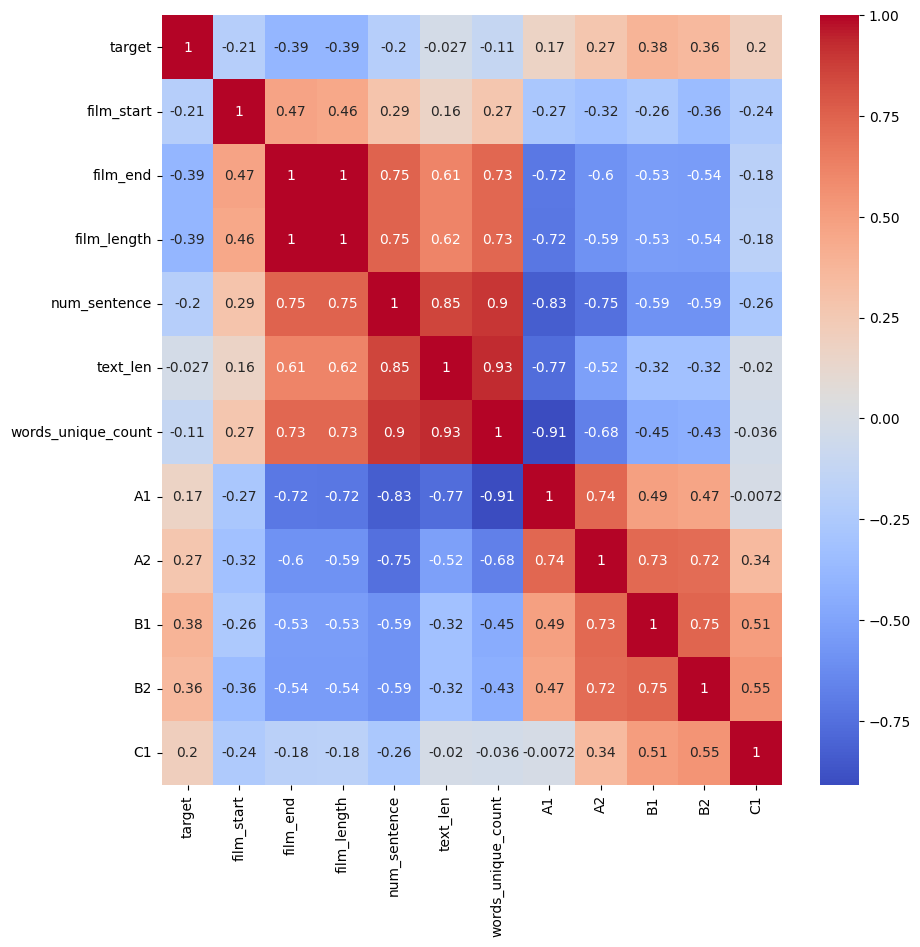

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
correlation_matrix = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [54]:
# Наш целевой столбец - это 'target'
features = df.drop('target', axis=1)
target = df['target']

In [55]:
# Обработаем значения
quantitative_vars = ['film_start', 'film_end', 'film_length', 'num_sentence', 'text_len', 'words_unique_count', 'A1', 'A2', 'B1', 'B2', 'C1']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)  

scaler = StandardScaler()
features_train[quantitative_vars] = scaler.fit_transform(features_train[quantitative_vars]) 
features_test[quantitative_vars] = scaler.transform(features_test[quantitative_vars]) 
features_train.head(5)

,film_start,film_end,film_length,num_sentence,text_len,words_unique_count,A1,A2,B1,B2,C1
73,-0.095348,0.679411,0.689801,0.405150,0.837136,0.799743,-0.041440,-0.470612,-0.320629,-1.322368,-0.471064
151,1.162348,0.971400,0.953993,0.295899,-0.258450,0.063855,0.102519,-0.130184,-0.192178,-1.176220,-0.891338
179,-0.539240,-1.027562,-1.026298,-0.425665,-0.607939,-0.561460,0.296778,-0.031713,0.035412,1.487263,-0.892111
156,-0.613222,-1.004403,-1.001027,-0.822017,-0.142243,-0.830269,1.101532,1.091547,1.294812,1.962273,0.314378
56,0.496509,1.271562,1.274240,1.000948,1.936552,1.581387,-1.023489,0.437859,-0.470887,-0.479769,0.983404


In [56]:

param_grid = {'iterations': [50, 100],
           'learning_rate': [0.01, 0.1],
                   'depth': [4, 6]}

model_cb = cb.CatBoostRegressor(random_state=12345, silent=True)
grid_cb = GridSearchCV(model_cb, param_grid, cv=3, scoring='neg_mean_squared_error')
grid_cb.fit(features_train, target_train)
best_params_cb = grid_cb.best_params_
print ('Лучшие параметры: ', grid_cb.best_params_)

Лучшие параметры:  {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}


In [58]:

# Создание модели CatBoostClassifier
model = CatBoostClassifier(**best_params_cb, random_state=12345, silent=True)

# Обучение модели
model.fit(features_train, target_train)

# Предсказание
preds = model.predict(features_test)

cv_scores_cb = -cross_val_score(model_cb, features_train, target_train, cv=3, scoring='neg_mean_squared_error')
rmse_cb = np.mean(np.sqrt(cv_scores_cb))

# Оценка точности модели
print("Accuracy:", accuracy_score(target_test, preds))
print(f"RMSE: {rmse_cb}")


Accuracy: 0.5172413793103449
RMSE: 0.6543203251290015


In [59]:
# Сохраним обученную модель для дальнейшего использования
model.save_model('english_level_model.cbm')